In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
import efficientnet.keras as efn
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import os
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
IMAGE_SIZE = [224, 224]
weight_size = 224
height_size = 224
batch_size = 32

In [3]:
train_path = './Dataset/train/'
valid_path = './Dataset/valid/'
test_path = './Dataset/test/'

### Data Exploration

In [4]:
# Get a list of classes (groups) in your dataset
classes = [class_name for class_name in sorted(os.listdir(train_path)) if not class_name.startswith('.')]
print("Classes:", classes)

Classes: ['kick', 'kicknt', 'punch', 'punchnt']


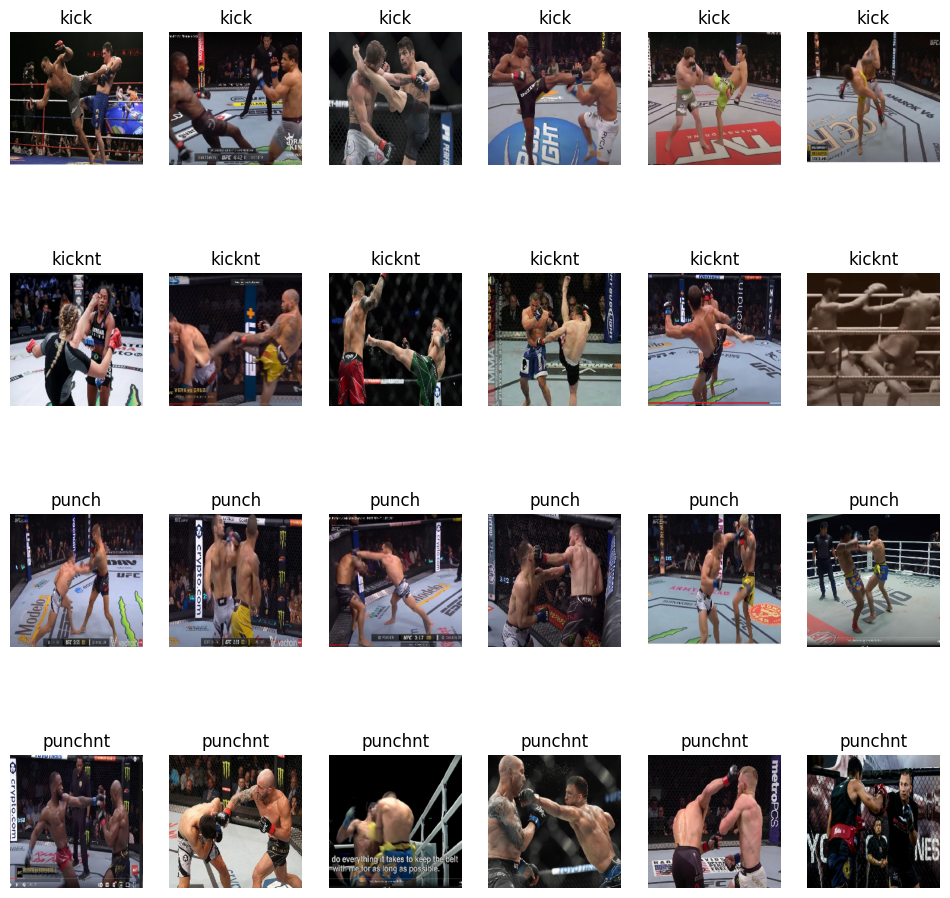

In [5]:
# Number of samples per class to display
num_samples_per_class = 6

# Function to display sample images from each class
def show_sample_images(data_dir, classes, num_samples_per_class):
    plt.figure(figsize=(12,12))

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        class_images = random.sample(os.listdir(class_dir), num_samples_per_class)

        for j, image_name in enumerate(class_images):
            image_path = os.path.join(class_dir, image_name)
            image = load_img(image_path, target_size=(weight_size, height_size))

            plt.subplot(len(classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Call the function to show sample images from each class
show_sample_images(train_path, classes, num_samples_per_class)


In [6]:
#folders = glob('data/train/*')

In [7]:
#len(folders)

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,           # Normalize pixel values to [0,1]
    rotation_range=90,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.4,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.4,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.5,             # Apply shear transformation
    zoom_range=0.2,              # Randomly zoom images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Use the nearest pixel to fill missing areas after augmentation
)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 409 images belonging to 4 classes.


In [12]:
test_set = test_datagen.flow_from_directory(test_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 60 images belonging to 4 classes.


In [13]:
valid_set = valid_datagen.flow_from_directory(valid_path,
                                             target_size=(224, 224),
                                             batch_size=batch_size,
                                             class_mode='categorical')

Found 128 images belonging to 4 classes.


### Displaying the augmentation of the images

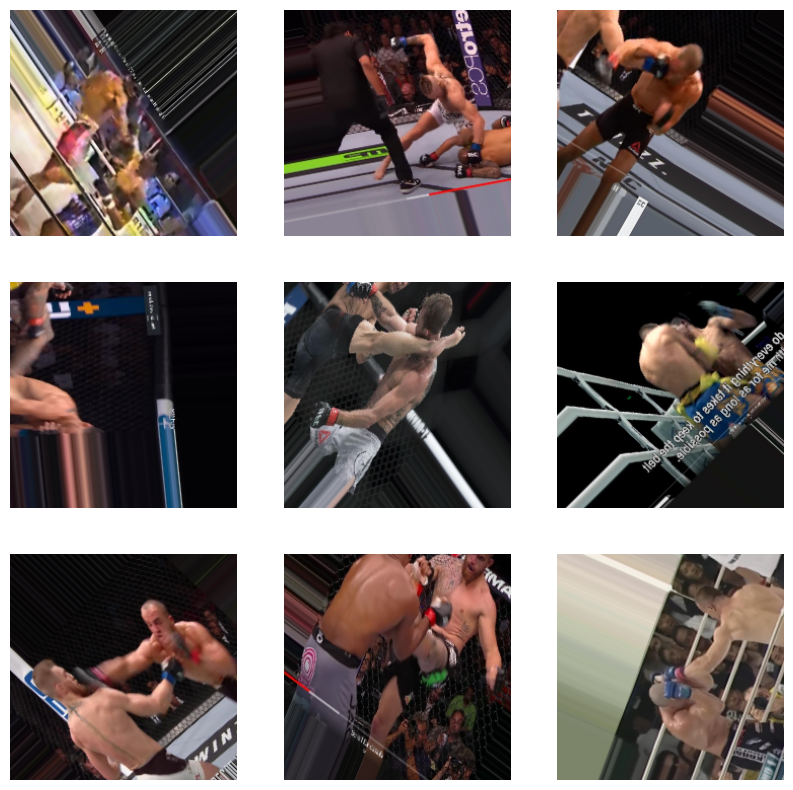

In [14]:
plt.figure(figsize=(10, 10))
images, _ = next(training_set)
for i, image in enumerate(images[: 9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis('off')

### MobileNETV2

In [15]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [16]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "ReLU"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "ReLU"),
                    Dropout(0.1),
                    Dense(32, activation = "ReLU"),
                    Dropout(0.3),
                    Dense(4, activation = "sigmoid")])

model.layers[0].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [17]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
EPOCHS = 50
hist = model.fit(training_set, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=valid_set)

Epoch 1/50


2023-08-03 21:01:15.849065: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1161/257187387.py", line 2, in <module>
      hist = model.fit(training_set, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=valid_set)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/backend.py", line 5565, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1161/257187387.py", line 2, in <module>
      hist = model.fit(training_set, epochs=EPOCHS, callbacks=[lr_callbacks], validation_data=valid_set)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/Users/zunushrestha/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/keras/backend.py", line 5565, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must be broadcastable: logits_size=[32,2] labels_size=[32,4]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]]
	 [[sequential/dense_3/BiasAdd/_20]]
  (1) INVALID_ARGUMENT:  logits and labels must be broadcastable: logits_size=[32,2] labels_size=[32,4]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_9250]

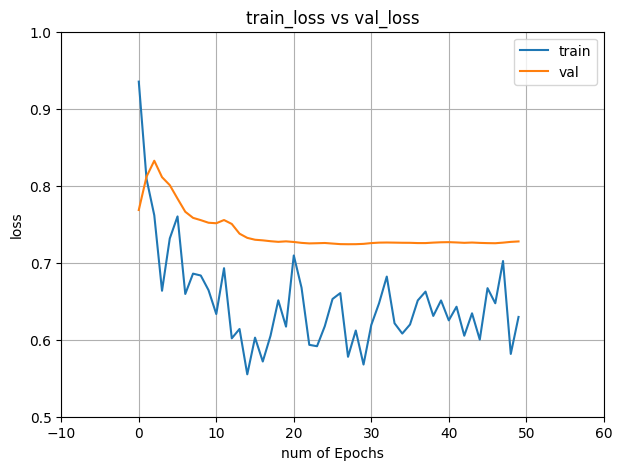

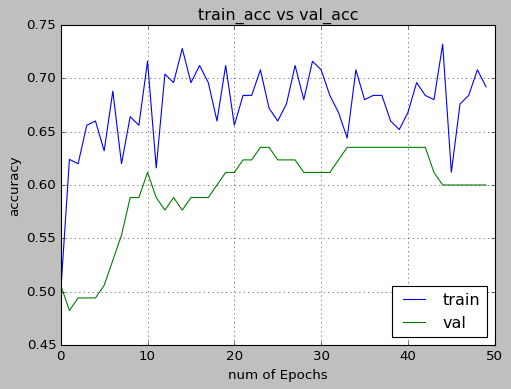

In [ ]:
epochs = 50
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

### Model Evaluation

#### Valid dataset accuracy

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1617/3858465583.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_set, verbose = 1)


3/3 [==============================] - 0s 78ms/step - loss: 0.7276 - accuracy: 0.6000
Validation Accuracy:  60.0 %


#### Test dataset accuracy

In [ ]:
test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

/var/folders/qn/c0ll_4m107d0w2b21m8wkgz80000gn/T/ipykernel_1617/1841467748.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(generator = test_set, verbose = 1)


1/1 [==============================] - 0s 212ms/step - loss: 0.6596 - accuracy: 0.5312
Test Accuracy:  53.12 %
